In [1]:
import numpy as np
import os
import pandas as pd

np.random.seed(23)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# Loading data
housing = pd.read_csv(os.path.join('datasets/housing/housing.csv'))
housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# Looking at a categorical variable
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


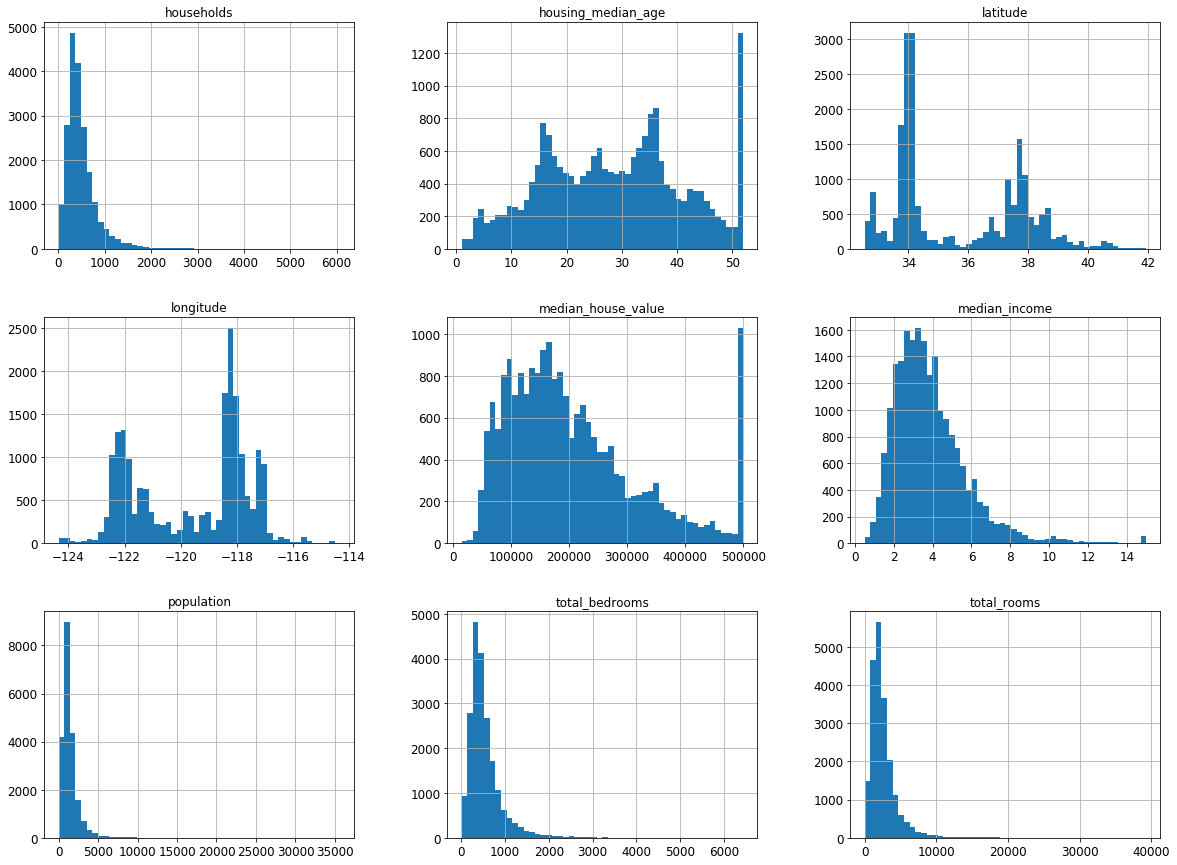

In [6]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Some notes about the data:
* median_income is not expressed in dollars
* house_median_age and median_house_value seem to be artificially limited, and are skewed. This might problematic specially for median_house_value which is out prediction target
* some distributions are tail heavy and have different scales, this will have to be dealt with

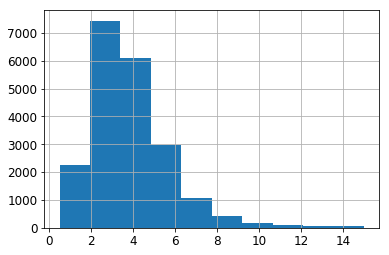

In [7]:
housing["median_income"].hist()

# Creating train/test set

In [8]:
# Before creating train/test sets let's stratify the data.
# We have been told median__income is a good predictor of house value, so we'll stratify here

# Scalling down and ceiling (to have discrete categories)
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

# Values higher than 5 are merged into 5 to limit categories
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

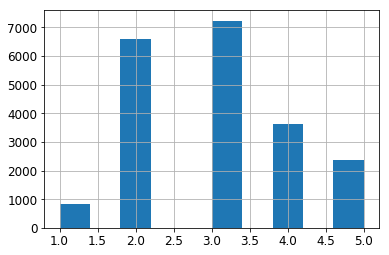

In [9]:
housing["income_cat"].hist()

In [10]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [11]:
# We don't need it anymore.
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

# Looking at the data

In [12]:
# Creating a copy to be sure
# If the data was too big I could have sampled it for explorations purposes,
# but with this dimentions that's not necessary

housing = strat_train_set.copy()

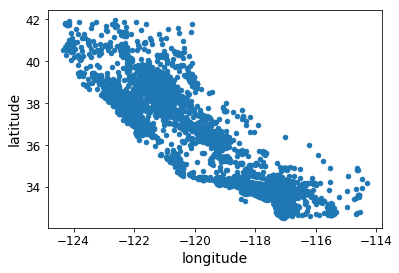

In [13]:
# Using coords conveniently (note this is a map of California)
housing.plot(kind="scatter", x="longitude", y="latitude")

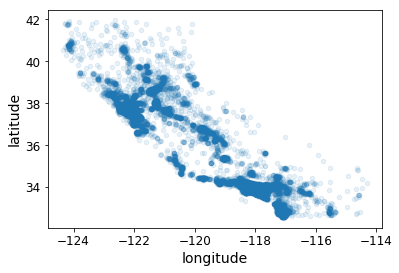

In [14]:
# Adding alpha to improve density perception
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

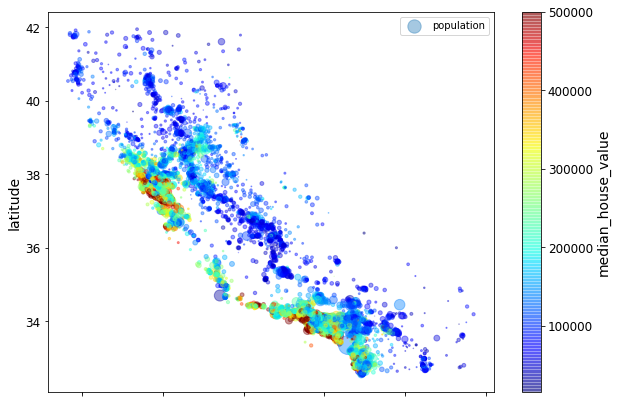

In [15]:
# Doing a little more: change are according to population, color according to price
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1110b2860>,
      dtype=object)

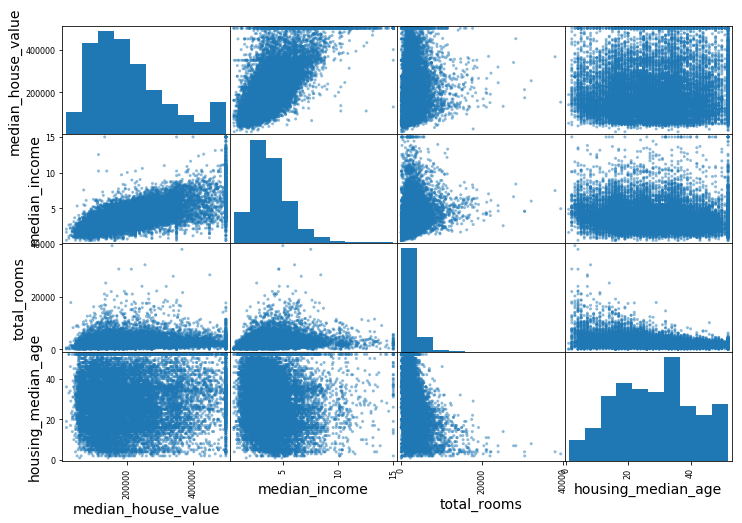

In [16]:
# Looking a correlations (this would be harder if dealing with large amounts of data)
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

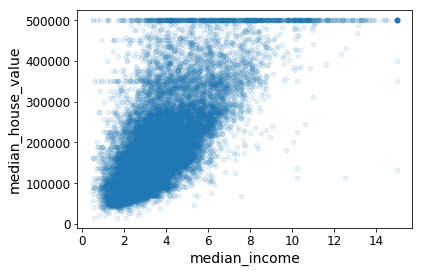

In [17]:
# Let's look closer at median_income because we know this is a good predictor
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

Some notes:
* There really seems to be a correlation
* There is a visible upper price cap 
* There seem to be other straight lines, points at some problems in the data

# Trying attribute combinations

In [18]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [19]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Some notes:
* bedrooms_per_room is much more correlated with the median house value than total number of rooms or bedroom
(aparently houses with a lower bedroom/room ratio tend to be more expensive)
* the number of rooms per household is also more informative than the total number of rooms
(obviously the larger the houses, the more expensive they are)

# Preparing data

In [20]:
housing = strat_train_set.drop("median_house_value", axis=1)  # drop() creates copy
housing_labels = strat_train_set["median_house_value"].copy()

In [21]:
# Some options for filling data are:
# These are just as a guide. We will use Imputer below to prepare the data

# Remove corresponding entries
# housing.dropna(subset=["total_bedrooms"])

# Remove the attribute
# housing.drop("total_bedrooms", axis=1)

# Fill gaps with something else (median for ex.)
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

In [22]:
# Feeling gaps with the median value using sklearn Inputer
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

# median can only be computer in numerical values, so we drop categorical variables
# We could do this only for the feature we know to have missing values, but in the future
#   we might have missing data somewhere else
housing_numerical = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_numerical)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [23]:
# imputer computed the median of each attribute and stored the result in statistics_
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [24]:
# Same as:
housing_numerical.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [25]:
# Now we can transform the training set
X = imputer.transform(housing_numerical)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [26]:
# The results is a numpy array, but we can transform it back into a dataframe
housing_tr = pd.DataFrame(X, columns=housing_numerical.columns)

### Looking at categorical variables now

In [27]:
housing_categorical = housing["ocean_proximity"]
housing_categorical.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [28]:
# Converting textual into numerical categories with factorize()
housing_cat_encoded, housing_categories = housing_categorical.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [29]:
# The index textual - numerical category
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [30]:
# Machine learning algorithms tend to look for numerical distances, even between categorical variable
# For this reason we create a one-hot encoding for each category individually

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [31]:
# Definition of the CategoricalEncoder class, copied from commit PR #9151.
# At some point CategoricalEncoder will be part of the sklearn stable release

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [32]:
# from sklearn.preprocessing import CategoricalEncoder
cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_categorical.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [33]:
# We could do this to create a "onehot-dense", which is the exact same thing

# cat_encoder = CategoricalEncoder(encoding="onehot-dense")
# housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
# housing_cat_1hot

In [34]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Using sklearn transformation pipelines

### Custom transformers for attribute combinations

In [35]:
# Creating a custom sklearn transformer for data treatment, another (better) solution for the implementations above
# TransformerMixin to obtain fit_transform() for free
# BaseEstimator to avoid *args and **kargs in the constructor and get two extra methods get_params() and set_params()

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [36]:
# First we create a Selector to select the attributes we want to be introduced in the pipeline
#   (for example to select numerical and categorical variables)
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [37]:
# Two pipelines, one for numerical, the other for categorical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(housing_numerical)
print(num_attribs)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [38]:
# Merging both pipelines
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [39]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Model Training

We have looked at the data, framed the problem, cleaned, wrote transformation pipelines, prepared the data. Now it's time for model training.

### Simple Linear Regression

Let's start to see what a simple linear regression can do

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849878]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Horrible predictions, first is of by some $70,000.

In [45]:
# Let's measure the model's RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

$68k is huge. We could try feature selection, add more attributes (such as logarithmic population) but let's try another prediction model technique.

### Decision Tree Regressor

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Something is very wrong with this model. Let's try something else

### Cross Validation

K-fold cross-validation: randomly splits the training set into 10 distinct subsets called folds, trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [53]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69413.10240603 67204.35702898 69748.3095682  69482.26606346
 70735.18712723 74616.61171909 70758.72647797 71747.07920862
 77621.56351426 70420.95097057]
Mean: 71174.81540844204
Standard deviation: 2800.652390043822


Cross-validation provides not only an estimate of the performance of your model, but also a measure of how precise this estimate is (standard deviation). The Decision Tree has a score of approximately 71k, generally ±2.8k.

In [54]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70361.18285107 74742.02420674
 68022.09224176 71191.82593104 64969.63056405 68276.69992785
 71543.69797334 67665.10082067]
Mean: 69051.5111027415
Standard deviation: 2732.2938055170403


Linear regression performs better than Decision Tree. Let's try random forests.

In [56]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22343.66205233705

In [58]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [52668.30805213 50180.69916976 51443.40890996 55097.93675221
 52047.79622226 55877.59276742 51878.10742465 50441.48383555
 55385.25661471 53375.23833907]
Mean: 52839.582808773055
Standard deviation: 1935.1379128654414


Random Forest performs the better.

# Tuning the model

GridSearchCV searches combinations of hyperparameters automatically. In total (3*4)+(2*6)=18 combinations of parameters will be tested 5 times each (cross folding `cv=5`) for a total 18*5=90 rounds of training. Keep scale issues in mind.

In [64]:
# RandomizedSearchCV has some advantages over GridSearchCV or they can complement each other 
#   (first search an optimal sub-space, then fine-tune it)

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [65]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

If GridSearchCV is initialized with refit=True (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance.

In [66]:
# To get the individual scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63392.64650154979 {'max_features': 2, 'n_estimators': 3}
55691.28806201791 {'max_features': 2, 'n_estimators': 10}
52604.338564467136 {'max_features': 2, 'n_estimators': 30}
60460.653302904204 {'max_features': 4, 'n_estimators': 3}
53189.101030117556 {'max_features': 4, 'n_estimators': 10}
50711.95982564273 {'max_features': 4, 'n_estimators': 30}
59576.07945103948 {'max_features': 6, 'n_estimators': 3}
51891.3094253669 {'max_features': 6, 'n_estimators': 10}
50010.4798054949 {'max_features': 6, 'n_estimators': 30}
59011.23376540574 {'max_features': 8, 'n_estimators': 3}
52260.92693329318 {'max_features': 8, 'n_estimators': 10}
50177.99905191547 {'max_features': 8, 'n_estimators': 30}
62650.982153267025 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53865.93793238466 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60655.19761900947 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52953.611157544896 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [67]:
# RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.50930071e-02, 6.30062285e-02, 4.62061834e-02, 1.90879533e-02,
       1.65810862e-02, 1.87601769e-02, 1.64076150e-02, 3.77309429e-01,
       5.44392046e-02, 1.03954958e-01, 5.97877236e-02, 9.51477895e-03,
       1.42783466e-01, 4.34302670e-05, 2.70501235e-03, 4.31974744e-03])

In [69]:
# Show attribute by its rating
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3773094285721578, 'median_income'),
 (0.14278346603087103, 'INLAND'),
 (0.10395495789520942, 'pop_per_hhold'),
 (0.06509300708236755, 'longitude'),
 (0.06300622846375949, 'latitude'),
 (0.05978772356155225, 'bedrooms_per_room'),
 (0.054439204551408917, 'rooms_per_hhold'),
 (0.04620618344723662, 'housing_median_age'),
 (0.019087953327408317, 'total_rooms'),
 (0.01876017694963256, 'population'),
 (0.016581086160258118, 'total_bedrooms'),
 (0.016407614952162287, 'households'),
 (0.00951477895130855, '<1H OCEAN'),
 (0.004319747441080707, 'NEAR OCEAN'),
 (0.002705012346565684, 'NEAR BAY'),
 (4.3430267020672794e-05, 'ISLAND')]

# Evaluate system on test set

In [73]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# IMPORTANT NOTE not to call fit or fit_transform. fit find parameters for scalling,
# fit_transform will find parameters and transform the data. Here we only want to
# transform using the values from the training set
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48348.98469321199